# 1. Importing Libraries

Just importing important libraries

In [2]:
# Important libraries
import numpy as np
import nengo
import pandas as pd
from nengo.ensemble import Ensemble
from nengo.connection import Connection
from nengo.node import Node
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 2. Loading Data

### 2.1 Basic File Properties

Make sure to save the entire raw data in 'Data Extration'.
There should be four files: MM_S1_raw.csv, MT_S1_raw.csv, MT_S2_raw.csv, MT_S3_raw.csv, 

In [5]:
# Change 'monkey' variable to the desired monkey dataset: MM_S1, MT_S1, MT_S2, MT_S3
monkey = "MM_S1"

# Datapath to get the raw data file (Stored in DataExtraction)
datafile_path = r"..\\..\\Data Extraction\\"+monkey+"_raw.csv"

### 2.2 Importing the dataset

Get the activity matrix and kinematic data from the files

In [6]:
data_df = pd.read_csv(datafile_path)
headers = data_df.columns.tolist()
n_neurons = sum("Neuron" in string for string in headers)


### 2.3 Preparing the data

In [7]:
# Getting the train activity and kinematic matrix
activity_matrix = data_df.loc[:, 'Neuron1':f'Neuron{n_neurons}']
kinem_matrix = data_df.loc[:, 'x_acceleration':'y_acceleration']

# Transpose data to ensure that dimensions are correct for decoder values
tranposed_activity_matrix = activity_matrix.transpose()
tranposed_kinem_matrix = kinem_matrix.transpose()

A = tranposed_activity_matrix.to_numpy()  # n_neurons x n_timepoints
Y = tranposed_kinem_matrix.to_numpy()    # n_kinematics x n_timepoints

# 3. Building the Minimal Effort Learning Model

### 3.1 Setting up and Adjusting Model Parameters

In [8]:
# Getting the input and output data for the model
spikes = A
scaler = np.max(Y)
kin_data = Y / scaler

# Model information
dt = 0.001
dti = 1/dt
spikes = spikes*dti

# Parameters to change
n_ensemble_neurons = 5000
ensemble_radius = 2
ensemble_synapse = 0.025
probe_synapse = 0.01

running_time = 150 # How long the model should run for
training_time = 0.8*running_time # WHen does the model stop learning

### 3.2 Implementing the Nengo Model

The image below is a visualization of the MELM model
![Architecture](MELM_architecture-A.png)

In [9]:
# Nengo Network Using Recorded Spikes as Input
np.random.seed(0)
with nengo.Network() as model:

    # Input signal
    input_node = nengo.Node(lambda t: spikes[:,int(t / dt) - 1])

    # Connect low-passed input to the first ensemble (neuron representation)
    representation_ensemble = nengo.Ensemble(n_neurons=n_ensemble_neurons, dimensions=n_neurons, radius = ensemble_radius)
    nengo.Connection(input_node, representation_ensemble, synapse=ensemble_synapse)

    # Connect first ensemble to output ensemble
    output_ensemble = nengo.Ensemble(n_neurons=n_ensemble_neurons, dimensions=2, radius = ensemble_radius)
    learn_conn = nengo.Connection(representation_ensemble, output_ensemble,  function=lambda x: [0, 0], learning_rule_type=nengo.PES(learning_rate=2e-4))

    # Connect output to error
    error_ensemble = nengo.Ensemble(n_neurons=n_ensemble_neurons, dimensions=2, radius = ensemble_radius)
    nengo.Connection(output_ensemble, error_ensemble)

    # Connect error to the learning connection
    nengo.Connection(error_ensemble, learn_conn.learning_rule)

    # Get ground truth value
    truth_node = nengo.Node(lambda t: kin_data[:,int(t/dt) -1])
    nengo.Connection(truth_node, error_ensemble, transform=-1)

    # Probe for graphing
    p_post = nengo.Probe(output_ensemble, synapse=probe_synapse)

    # Stop learning after 80% of the running time has passed
    stop_learning = nengo.Node(output=lambda t: t >= training_time)
    nengo.Connection(
        stop_learning, error_ensemble.neurons, transform=-20 * np.ones((error_ensemble.n_neurons, 1))
    )

### 3.3 Running the Model and Plotting the Output

Build finished in 0:00:20.                                                      
Simulation finished in 0:02:15.                                                 


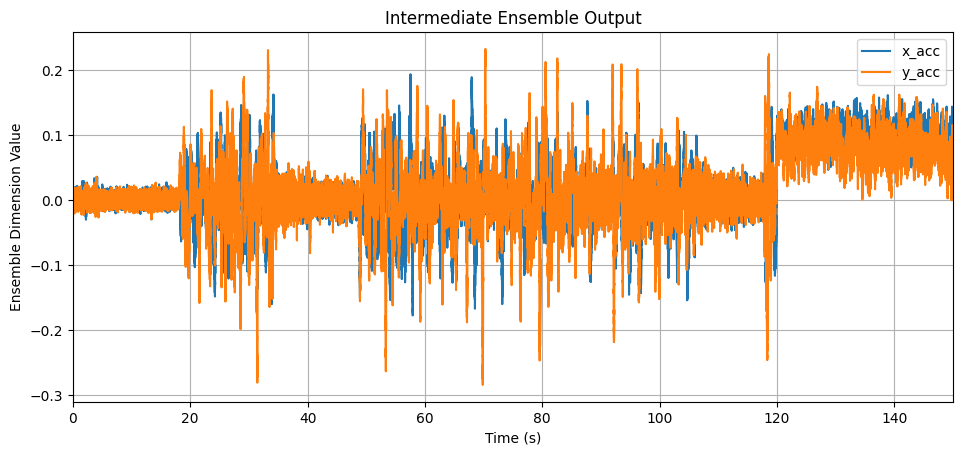

In [10]:
with nengo.Simulator(model, dt=dt, seed=0) as sim:
    sim.run(running_time)

fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_post])
pl.set_title("Intermediate Ensemble Output")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["x_acc", "y_acc"])
pl.grid()

# 4. Plotting and Comparing the Outputs

### 4.1 Plotting Predicted vs Actual Acceleration

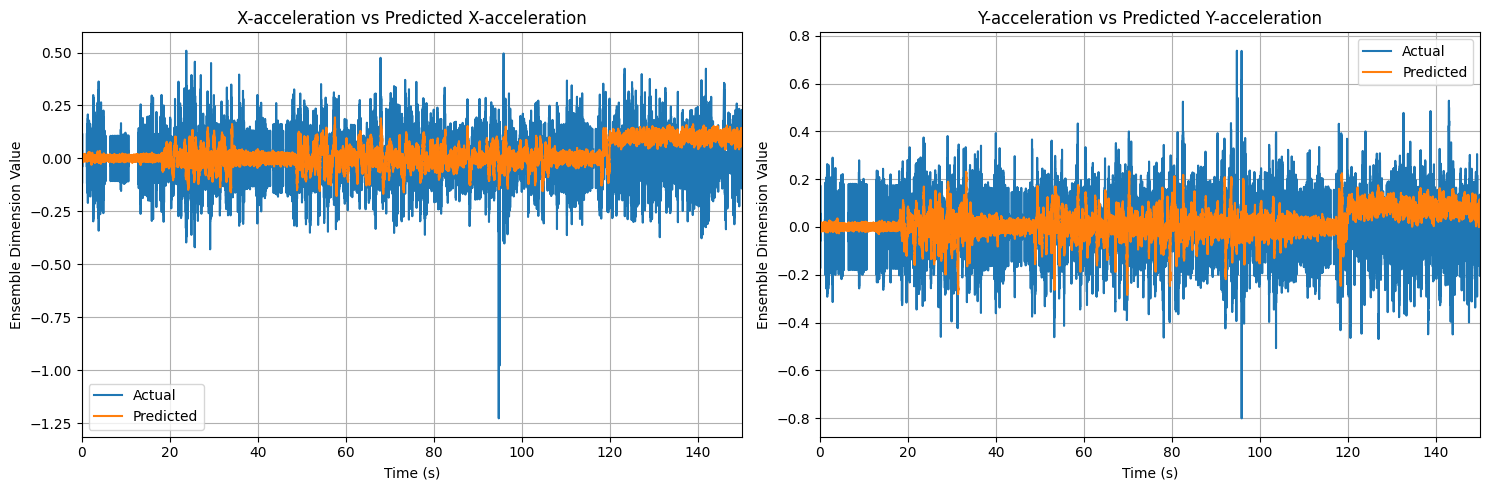

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(sim.trange(), kin_data[0, 0:len(sim.trange())])
ax1.plot(sim.trange(), sim.data[p_post][:, 0])
ax1.set_title("X-acceleration vs Predicted X-acceleration")
ax1.set_xlim((0,np.max(sim.trange())))
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Ensemble Dimension Value")
ax1.legend(["Actual", "Predicted"])
ax1.grid()

ax2.plot(sim.trange(), kin_data[1, 0:len(sim.trange())])
ax2.plot(sim.trange(), sim.data[p_post][:, 1])
ax2.set_title("Y-acceleration vs Predicted Y-acceleration")
ax2.set_xlim((0,np.max(sim.trange())))
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Ensemble Dimension Value")
ax2.legend(["Actual", "Predicted"])
ax2.grid()

fig.tight_layout()
plt.show()

# 5. Evautating Effectiveness of the Model

### 5.1 Implementing the Error Functions

In [13]:
def GetErrors(truth, predicted):
    # ax := ground truth x acceleration, ay := ground truth y acceleration
    # sim.data[p_a] := 2-dimensional output with 0th dimension corresponding to x and 1st dimension corresponding to y
    e_mae = np.sum(np.abs(truth - predicted)) / truth.shape[0]
    e_rmse = np.sqrt(np.sum(np.power(truth - predicted, 2)) / truth.shape[0])
    print("Mean Absolute Error: " + str(e_mae))
    print("Root Mean_Squared Error: " + str(e_rmse))

### 5.2 Calculating Errors

In [14]:
# X-Acceleration Error
print("X-Acceleration Error")
GetErrors(kin_data[0, 0:len(sim.trange())], sim.data[p_post][:, 0])
print("")

# Y-Acceleration Error
print("Y-Acceleration Error")
GetErrors(kin_data[1, 0:len(sim.trange())], sim.data[p_post][:, 1])
print("")

X-Acceleration Error
Mean Absolute Error: 0.06784230686300863
Root Mean_Squared Error: 0.09514212964975283

Y-Acceleration Error
Mean Absolute Error: 0.07614290325985762
Root Mean_Squared Error: 0.107321969965723



# 6. Validating by Comparing Velocities

### 6.1 Getting the acceleration data

In [16]:
# Get the truth acceleration and the predicted acceleration from the moel
true_accels = kin_data[:, 0:len(sim.trange())]
pred_accels = [ sim.data[p_post][:, 0], sim.data[p_post][:, 1] ]

# Scale the accelerations by the normalization constant to provide true units
true_accels = np.array(true_accels) * scaler
pred_accels = np.array(pred_accels) * scaler

### 6.2 Calculating the velocities by integration

Since acceleration is the derivative of the velocity, we can integrate the acceleration (or sum the acceleration) to find the instantaneous velocities at time t.

In [17]:
# Get the truth velocities from the truth acceleration
true_vels = []
for i in range(2):
    vel = []
    velsum = 0
    for j in range(len(true_accels[0])):
        velsum += true_accels[i][j] * dt
        vel.append(velsum)

    true_vels.append(vel)

# Get the predicted velocities from the predicted acceleration
pred_vels = []
for i in range(2):
    vel = []
    velsum = 0
    for j in range(len(true_accels[0])):
        velsum += pred_accels[i][j] * dt
        vel.append(velsum)

    pred_vels.append(vel)

### 6.3 Comparing Predicted and Actual Velocities

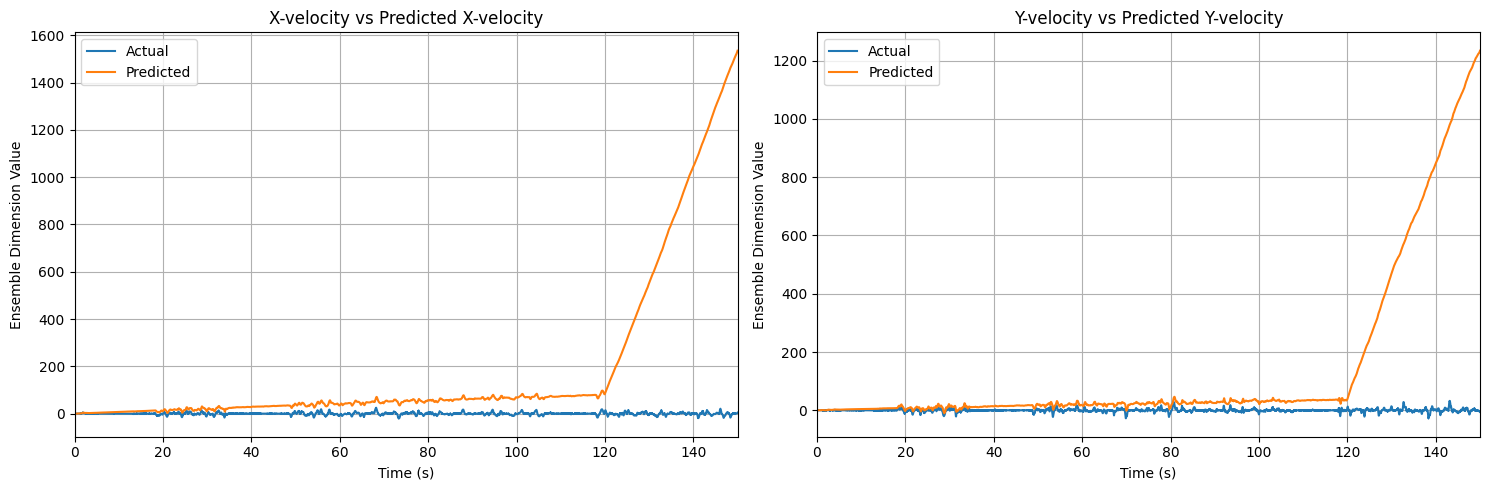

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(sim.trange(), true_vels[0])
ax1.plot(sim.trange(), pred_vels[0])
ax1.set_title("X-velocity vs Predicted X-velocity")
ax1.set_xlim((0,np.max(sim.trange())))
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Ensemble Dimension Value")
ax1.legend(["Actual", "Predicted"])
ax1.grid()

ax2.plot(sim.trange(), true_vels[1])
ax2.plot(sim.trange(), pred_vels[1])
ax2.set_title("Y-velocity vs Predicted Y-velocity")
ax2.set_xlim((0,np.max(sim.trange())))
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Ensemble Dimension Value")
ax2.legend(["Actual", "Predicted"])
ax2.grid()

fig.tight_layout()
plt.show()